# 块 0：统一环境与配置（合并重复 import）

In [ ]:
import sys, subprocess, os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple, Dict

def _ensure_package(pkg: str):
    """缺库时自动安装（Colab 友好；本地也可用）"""
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

_ensure_package("mne")
_ensure_package("scipy")
_ensure_package("sklearn")

import mne
from scipy.signal import butter, filtfilt, resample, welch
from scipy.integrate import simpson

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    precision_recall_curve,
    average_precision_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# === 你当前实验只用单文件 ===
EDF_FILE = "/content/drive/MyDrive/chb01_03.edf"
SUMMARY_FILE = "/content/drive/MyDrive/chb01-summary.txt"
TARGET_FILE = "chb01_03.edf"

# 滤波设置（主链路 + sanity check 统一）
FILTER_HP = 0.5
FILTER_LP = 40.0
FILTER_ORDER = 4

# 可选：是否输出调试图（你要精简就关掉）
DEBUG_PLOTS = True

# Colab：挂载 Drive（非 Colab 会自动跳过）
try:
    from google.colab import drive
    drive.mount("/content/drive")
except Exception:
    print("不是 Colab 环境，已跳过 drive.mount。")


def bandpass_filter(data: np.ndarray, fs: float, hp: float = FILTER_HP, lp: float = FILTER_LP, order: int = FILTER_ORDER) -> np.ndarray:
    """Bandpass filter along the last axis."""
    nyq = 0.5 * fs
    b, a = butter(order, [hp / nyq, lp / nyq], btype="band")
    return filtfilt(b, a, data, axis=-1)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 块 1：单通道 sanity check（可选）

读取 EDF（只读一次，后续全部复用 raw）...


/tmp/ipython-input-39876039.py:56: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(EDF_FILE, preload=True, verbose=False)


EDF 读取完成。


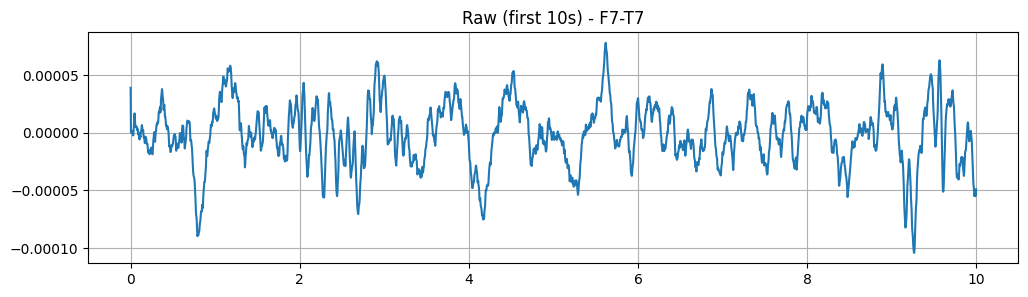

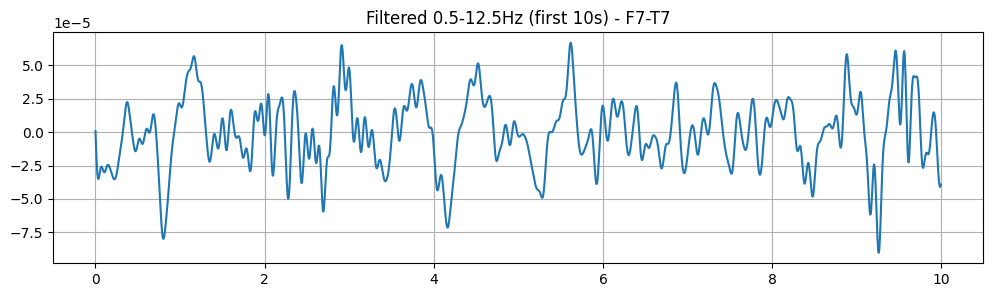

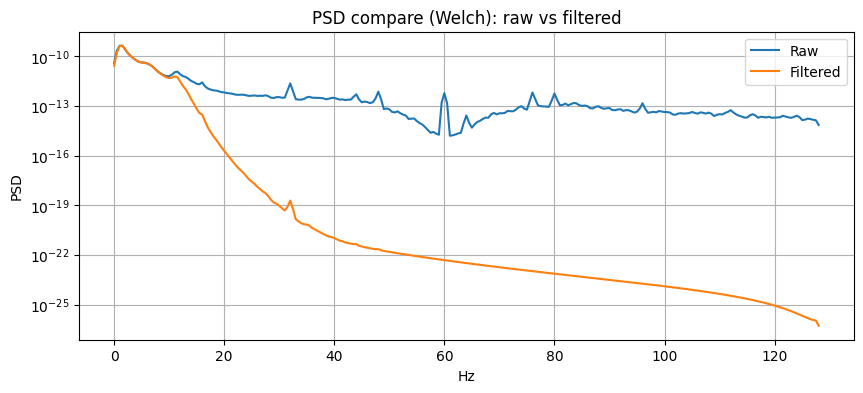

In [ ]:
# 优化理由：
# 1) 原 notebook 的单通道导出 CSV 不是主链路必须，可作为可选 sanity check。
# 2) sanity check 只需要做一次，确认“能读、滤波有效、频谱合理”。

def process_single_channel_sanity(
    raw_obj: mne.io.BaseRaw,
    channel_name: str = "F7-T7",
    hp: float = FILTER_HP,
    lp: float = FILTER_LP,
    target_fs: int = 32,
    order: int = FILTER_ORDER
) -> Dict[str, object]:
    if channel_name not in raw_obj.ch_names:
        raise ValueError(f"通道 {channel_name} 不存在！可用通道示例：{raw_obj.ch_names[:10]}")

    fs = raw_obj.info["sfreq"]
    x = raw_obj.get_data(picks=[channel_name]).squeeze()

    # bandpass
    x_f = bandpass_filter(x, fs, hp=hp, lp=lp, order=order)

    # downsample
    n_new = int(len(x_f) * target_fs / fs)
    x_ds = resample(x_f, n_new)

    # PSD（Welch）
    f0, p0 = welch(x, fs=fs, nperseg=int(fs*2))
    f1, p1 = welch(x_f, fs=fs, nperseg=int(fs*2))

    if DEBUG_PLOTS:
        plt.figure(figsize=(12, 3))
        t = np.arange(int(fs*10))/fs
        plt.plot(t, x[:int(fs*10)])
        plt.title(f"Raw (first 10s) - {channel_name}")
        plt.grid(True); plt.show()

        plt.figure(figsize=(12, 3))
        plt.plot(t, x_f[:int(fs*10)])
        plt.title(f"Filtered {hp}-{lp}Hz (first 10s) - {channel_name}")
        plt.grid(True); plt.show()

        plt.figure(figsize=(10, 4))
        plt.semilogy(f0, p0, label="Raw")
        plt.semilogy(f1, p1, label="Filtered")
        plt.title("PSD compare (Welch): raw vs filtered")
        plt.xlabel("Hz"); plt.ylabel("PSD"); plt.grid(True); plt.legend(); plt.show()

    return {"fs": fs, "raw": x, "filtered": x_f, "downsampled": x_ds, "target_fs": target_fs}

print("读取 EDF（只读一次，后续全部复用 raw）...")
raw = mne.io.read_raw_edf(EDF_FILE, preload=True, verbose=False)
print("EDF 读取完成。")

if DEBUG_PLOTS:
    sanity = process_single_channel_sanity(raw, channel_name="F7-T7", hp=FILTER_HP, lp=FILTER_LP, target_fs=32)


# 块 2：全通道数据 + 分窗切片（主链路开始）

In [ ]:
# 优化理由：
# 1) 原 notebook 多次 read_raw_edf、重复 segment；这里统一一次性做完并复用 seg。
# 2) seg 结构包含 epochs + 时间索引，后续标签/特征/评估都依赖它。

def segment_eeg_into_epochs(
    eeg: np.ndarray,      # (C, N)
    sfreq: float,
    ch_names: List[str],
    epoch_len_s: float = 2.0
) -> Dict[str, object]:
    epoch_len_samples = int(epoch_len_s * sfreq)
    C, N = eeg.shape
    n_epochs = N // epoch_len_samples

    trimmed = eeg[:, :n_epochs * epoch_len_samples]
    epochs = trimmed.reshape(C, n_epochs, epoch_len_samples).transpose(1, 0, 2)  # (E, C, S)

    start_samples = np.arange(n_epochs) * epoch_len_samples
    end_samples = start_samples + epoch_len_samples

    return {
        "epochs": epochs,
        "sfreq": sfreq,
        "ch_names": ch_names,
        "epoch_len_s": epoch_len_s,
        "epoch_len_samples": epoch_len_samples,
        "epoch_start_times": start_samples / sfreq,
        "epoch_end_times": end_samples / sfreq,
        "n_epochs": n_epochs
    }

sfreq = raw.info["sfreq"]
ch_names = raw.ch_names
eeg_data = raw.get_data()  # (C, N)

print(f"sfreq={sfreq}, channels={len(ch_names)}, data shape={eeg_data.shape}")

print(f"应用带通滤波：{FILTER_HP}-{FILTER_LP} Hz (order={FILTER_ORDER})")
eeg_data = bandpass_filter(eeg_data, sfreq)

seg = segment_eeg_into_epochs(eeg_data, sfreq, ch_names, epoch_len_s=2.0)
print(f"epochs shape: {seg['epochs'].shape} = (n_epochs, n_channels, epoch_len_samples)")


sfreq=256.0, channels=23, data shape=(23, 921600)
epochs shape: (1800, 23, 512) = (n_epochs, n_channels, epoch_len_samples)


# 块 3：epoch 可视化检查（可选）

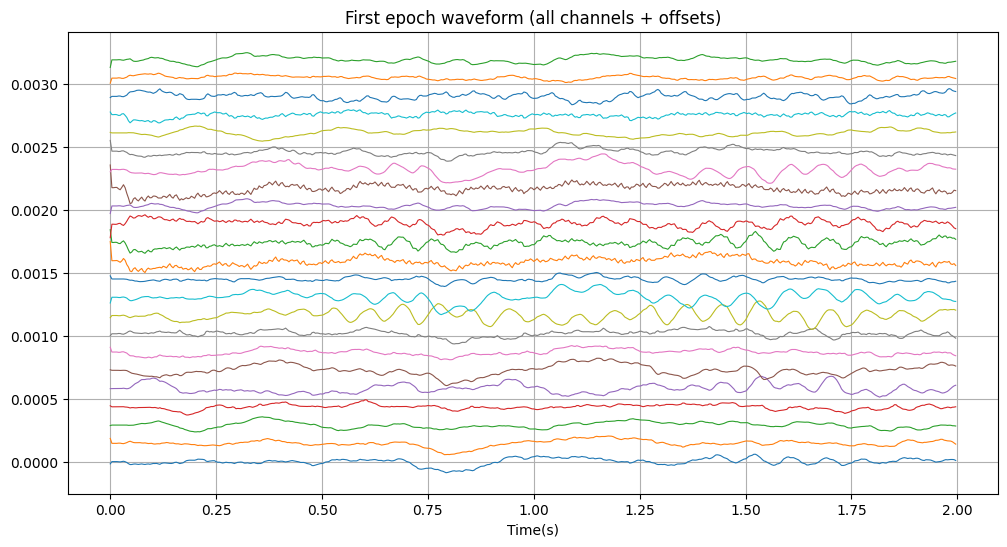

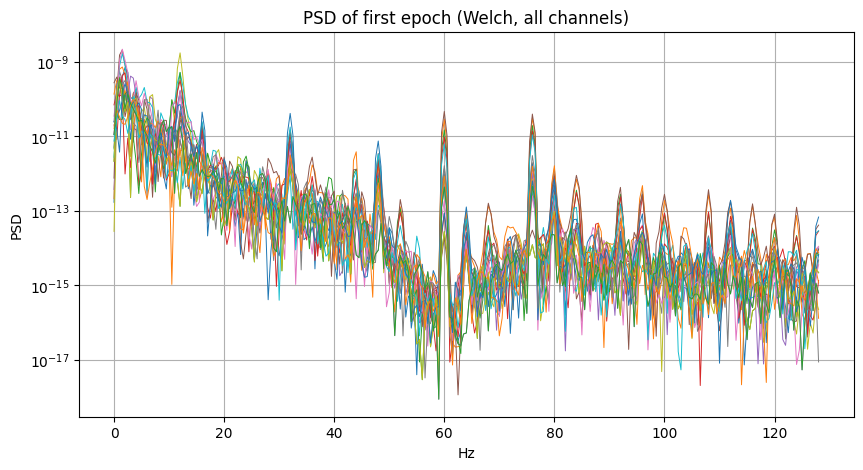

In [ ]:
# 优化理由：
# 1) 原 notebook 分散在多个块（画第一个、随机、PSD），这里合并为一个可选块。
# 2) 你要精简时可以直接关闭 DEBUG_PLOTS 或跳过该块，不影响主流程。

if DEBUG_PLOTS:
    ep0 = seg["epochs"][0]  # (C, S)
    t = np.arange(seg["epoch_len_samples"]) / seg["sfreq"]
    offset = np.mean(np.std(ep0, axis=1)) * 5

    plt.figure(figsize=(12, 6))
    for i in range(ep0.shape[0]):
        plt.plot(t, ep0[i] + i*offset, linewidth=0.8)
    plt.title("First epoch waveform (all channels + offsets)")
    plt.xlabel("Time(s)"); plt.grid(True); plt.show()

    plt.figure(figsize=(10, 5))
    for i in range(ep0.shape[0]):
        f, p = welch(ep0[i], fs=seg["sfreq"], nperseg=seg["epoch_len_samples"])
        plt.semilogy(f, p, linewidth=0.7)
    plt.title("PSD of first epoch (Welch, all channels)")
    plt.xlabel("Hz"); plt.ylabel("PSD"); plt.grid(True); plt.show()


# 块 4：定义特征提取（空间快照向量）

In [ ]:
# 优化理由：
# 1) 把频带定义集中管理，后续改频带/做对比实验更方便。
# 2) 输出结构固定：每通道 4 个 band energy + 1 个 RMS => 5 个特征/通道。

BANDS = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta":  (13, 30),
}

def extract_spatial_features(epoch_data: np.ndarray, fs: float) -> np.ndarray:
    """
    输入 epoch_data: (C, S)
    输出：1D 向量，按通道展开拼接：
    [ch1_delta, ch1_theta, ch1_alpha, ch1_beta, ch1_rms, ch2_delta, ...]
    """
    C, S = epoch_data.shape
    feats = []

    for c in range(C):
        x = epoch_data[c]
        freqs, psd = welch(x, fs=fs, nperseg=S)

        for (f_low, f_high) in BANDS.values():
            idx = (freqs >= f_low) & (freqs < f_high)
            feats.append(simpson(psd[idx], freqs[idx]) if np.any(idx) else 0.0)

        feats.append(np.sqrt(np.mean(x**2)))  # RMS

    return np.array(feats, dtype=float)


# 块 5：批量特征提取（X_spatial）

In [ ]:
# 优化理由：
# 1) 原 notebook 逻辑正确，这里只做结构更清晰+一次性 vstack。
# 2) 加进度输出，跑大文件更友好。

print("开始批量提取空间特征 X_spatial ...")
X_spatial = np.vstack([extract_spatial_features(seg["epochs"][i], seg["sfreq"]) for i in range(seg["n_epochs"])])
print(f"X_spatial shape = {X_spatial.shape} (n_epochs, n_features_per_epoch)")


开始批量提取空间特征 X_spatial ...
X_spatial shape = (1800, 115) (n_epochs, n_features_per_epoch)


# 块 6：解析 seizure 时间区间（只针对 TARGET_FILE）

In [ ]:
# 优化理由：
# 1) 明确只解析一个文件段落（与你当前实验一致）。
# 2) 输出 List[(start_s, end_s)]，便于标签生成。

def parse_seizure_times(summary_path: str, target_edf_name: str) -> List[Tuple[float, float]]:
    with open(summary_path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.strip() for ln in f.readlines()]

    seizure_intervals = []
    current_file = None
    starts, ends = [], []

    for line in lines:
        m_file = re.match(r"File Name:\s*(.*)", line)
        if m_file:
            # 进入新文件前，若上一段是目标文件则写入
            if current_file == target_edf_name:
                seizure_intervals.extend(list(zip(starts, ends)))
            current_file = m_file.group(1).strip()
            starts, ends = [], []
            continue

        if current_file != target_edf_name:
            continue

        m_s = re.match(r"Seizure Start Time:\s*(\d+)\s*seconds", line)
        m_e = re.match(r"Seizure End Time:\s*(\d+)\s*seconds", line)
        if m_s: starts.append(float(m_s.group(1)))
        if m_e: ends.append(float(m_e.group(1)))

    if current_file == target_edf_name:
        seizure_intervals.extend(list(zip(starts, ends)))

    return seizure_intervals

seizure_times = parse_seizure_times(SUMMARY_FILE, TARGET_FILE)
print(f"Target EDF = {TARGET_FILE}")
print("Seizure intervals (seconds):", seizure_times)


Target EDF = chb01_03.edf
Seizure intervals (seconds): [(2996.0, 3036.0)]


# 块 7：生成 epoch 标签 y_labels

In [ ]:
# 优化理由：
# 1) 标签规则明确：epoch 时间窗与任一 seizure 区间有重叠 => 1。
# 2) 做 X/y 对齐检查，避免隐性错位。

def create_labels(seg: Dict[str, object], seizure_intervals: List[Tuple[float, float]]) -> np.ndarray:
    y = np.zeros(seg["n_epochs"], dtype=int)
    for i in range(seg["n_epochs"]):
        t0, t1 = seg["epoch_start_times"][i], seg["epoch_end_times"][i]
        for (s, e) in seizure_intervals:
            if (t0 < e) and (t1 > s):  # overlap
                y[i] = 1
                break
    return y

y_labels = create_labels(seg, seizure_times)

print(f"y_labels shape = {y_labels.shape}")
print("label counts:", {0: int((y_labels==0).sum()), 1: int((y_labels==1).sum())})
assert X_spatial.shape[0] == y_labels.shape[0], "X_spatial 和 y_labels 行数不一致！"
print("✅ X_spatial 与 y_labels 对齐。")


y_labels shape = (1800,)
label counts: {0: 1780, 1: 20}
✅ X_spatial 与 y_labels 对齐。


# 块 8：时空演化向量（W=3 拼接）

In [ ]:
# 优化理由：
# 1) 把短时序上下文引入特征（你当前方法核心之一）。
# 2) y 对齐到窗口最后一个 epoch（与你原实现一致）。

W = 3

X_final = np.vstack([X_spatial[i-(W-1):i+1].reshape(-1) for i in range(W-1, X_spatial.shape[0])])
y_final = np.array([y_labels[i] for i in range(W-1, y_labels.shape[0])], dtype=int)

print(f"X_final shape = {X_final.shape}")
print(f"y_final shape = {y_final.shape}")
print("final label counts:", {0: int((y_final==0).sum()), 1: int((y_final==1).sum())})


X_final shape = (1798, 345)
y_final shape = (1798,)
final label counts: {0: 1778, 1: 20}


# 块 9：训练与基础评估 + 新增模块A（类别比例&naive baseline）

--- 数据概览（新增模块A） ---
Total samples: 1798 | Non-seizure: 1778 | Seizure: 20 | Pos rate: 0.0111
Train: 1258 | Test: 540 | Test positives: 6
训练 SVM ...
训练完成。

[1] 分类报告（SVM）
                 precision    recall  f1-score   support

Non-Seizure (0)       0.99      1.00      0.99       534
    Seizure (1)       0.00      0.00      0.00         6

       accuracy                           0.99       540
      macro avg       0.49      0.50      0.50       540
   weighted avg       0.98      0.99      0.98       540

[2] 混淆矩阵（SVM）


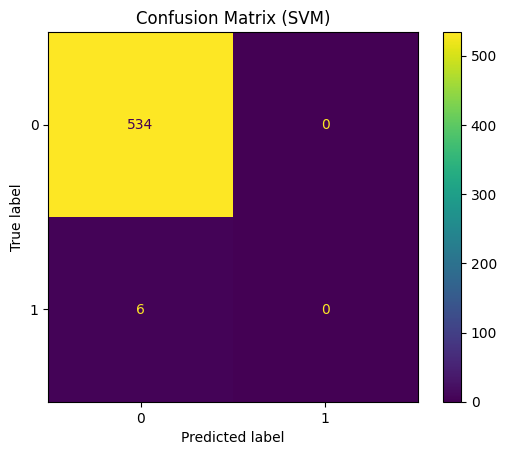

[3] ROC/AUC（SVM）
AUC = 0.9934


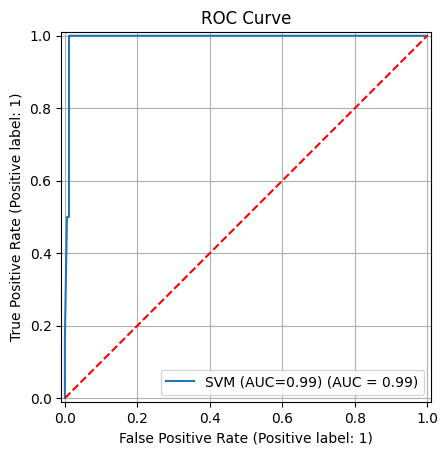


--- naive baseline（新增模块A）---
Naive confusion matrix:
 [[534   0]
 [  6   0]]
Naive accuracy = 0.9889, Naive balanced accuracy = 0.5000


In [ ]:
# 新增模块A优化理由：
# 你的数据极不平衡（测试集中 seizure 只有几个），accuracy 会被多数类“抬高”。
# 这里加入 naive baseline（全部预测为0），让你在报告里能清楚说明“高accuracy不代表检出发作”。

X = X_final
y = y_final

print("--- 数据概览（新增模块A） ---")
pos = int((y==1).sum())
neg = int((y==0).sum())
print(f"Total samples: {len(y)} | Non-seizure: {neg} | Seizure: {pos} | Pos rate: {pos/len(y):.4f}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

print(f"Train: {len(y_train)} | Test: {len(y_test)} | Test positives: {(y_test==1).sum()}")

# 标准化
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 训练 SVM（与你原设定一致）
clf = SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=RANDOM_STATE)
print("训练 SVM ...")
clf.fit(X_train_s, y_train)
print("训练完成。")

# 预测
y_pred = clf.predict(X_test_s)
y_score = clf.predict_proba(X_test_s)[:, 1]

print("\n[1] 分类报告（SVM）")
print(classification_report(
    y_test, y_pred,
    target_names=["Non-Seizure (0)", "Seizure (1)"],
    zero_division=0
))

print("[2] 混淆矩阵（SVM）")
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["0","1"]).plot(values_format="d")
plt.title("Confusion Matrix (SVM)")
plt.show()

print("[3] ROC/AUC（SVM）")
auc = roc_auc_score(y_test, y_score)
print(f"AUC = {auc:.4f}")
RocCurveDisplay.from_predictions(y_test, y_score, name=f"SVM (AUC={auc:.2f})")
plt.plot([0, 1], [0, 1], "r--")
plt.grid(True)
plt.title("ROC Curve")
plt.show()

# ===== 新增：naive baseline（全部预测 0）=====
print("\n--- naive baseline（新增模块A）---")
y_pred_naive = np.zeros_like(y_test)
cm_naive = confusion_matrix(y_test, y_pred_naive)
acc_naive = (cm_naive[0,0] + cm_naive[1,1]) / cm_naive.sum()
# balanced accuracy
tpr = cm_naive[1,1] / (cm_naive[1,0] + cm_naive[1,1] + 1e-12)
tnr = cm_naive[0,0] / (cm_naive[0,0] + cm_naive[0,1] + 1e-12)
bal_acc_naive = 0.5 * (tpr + tnr)

print("Naive confusion matrix:\n", cm_naive)
print(f"Naive accuracy = {acc_naive:.4f}, Naive balanced accuracy = {bal_acc_naive:.4f}")


# 块 10：新增模块B（阈值扫描）+ 新增模块C（PR曲线/AP）

[PR] Average Precision (AP) = 0.5591


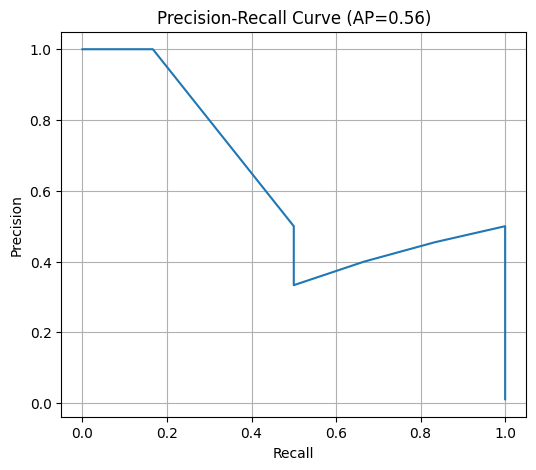


[Threshold Scan] 找到一个能检出 seizure 的阈值候选：
threshold         0.220000
precision         0.500000
recall            1.000000
fpr               0.011236
balanced_acc      0.994382
tp                6.000000
fp                6.000000
fn                0.000000
tn              528.000000
Name: 22, dtype: float64


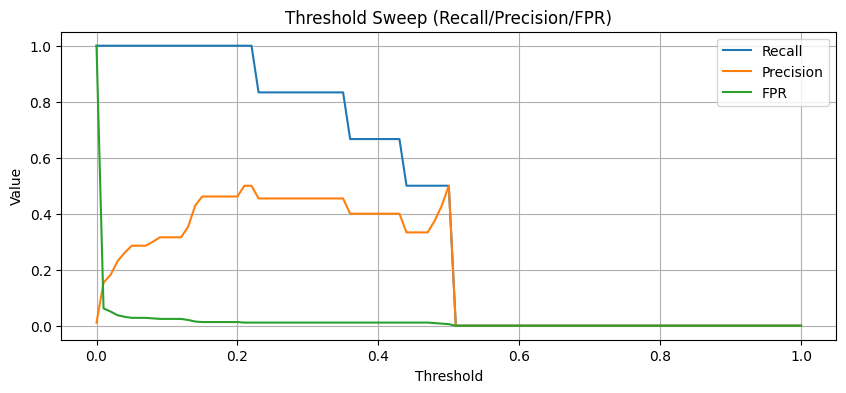

In [ ]:
# 新增模块B优化理由：
# 你现在默认阈值(≈0.5)下可能全部预测为0 -> recall=0；
# 但 AUC 衡量的是“排序能力”，阈值不同可能会出现可检出的操作点。
#
# 新增模块C优化理由：
# 在极不平衡任务中 PR/AP 比 ROC/AUC 更能反映正类检出能力。

# ------- (C) PR 曲线 & AP -------
precision, recall, thr_pr = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)
print(f"[PR] Average Precision (AP) = {ap:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP={ap:.2f})")
plt.grid(True)
plt.show()

# ------- (B) 阈值扫描：找到能检出 seizure 的阈值 -------
thresholds = np.linspace(0.0, 1.0, 101)

rows = []
for th in thresholds:
    y_hat = (y_score >= th).astype(int)
    cm_t = confusion_matrix(y_test, y_hat, labels=[0,1])
    tn, fp, fn, tp = cm_t.ravel()

    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)   # sensitivity
    fpr  = fp / (fp + tn + 1e-12)
    tnr  = tn / (tn + fp + 1e-12)
    bal  = 0.5 * (rec + tnr)

    rows.append([th, prec, rec, fpr, bal, tp, fp, fn, tn])

scan_df = pd.DataFrame(rows, columns=["threshold","precision","recall","fpr","balanced_acc","tp","fp","fn","tn"])

# 找“能检出正类”的阈值（recall>0）中，balanced_acc 最大的一个
cand = scan_df[scan_df["recall"] > 0]
if len(cand) == 0:
    print("阈值扫描结果：在所有阈值下 recall 仍为 0（模型对正类打分过低或正类太少）。")
else:
    best = cand.sort_values("balanced_acc", ascending=False).iloc[0]
    print("\n[Threshold Scan] 找到一个能检出 seizure 的阈值候选：")
    print(best)

# 画“阈值-Recall / 阈值-Precision / 阈值-FPR”
plt.figure(figsize=(10, 4))
plt.plot(scan_df["threshold"], scan_df["recall"], label="Recall")
plt.plot(scan_df["threshold"], scan_df["precision"], label="Precision")
plt.plot(scan_df["threshold"], scan_df["fpr"], label="FPR")
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.title("Threshold Sweep (Recall/Precision/FPR)")
plt.grid(True)
plt.legend()
plt.show()
